# **Άσκηση στους Autoencoders**

Στα πλαίσια της άσκησης θα εξετάσετε πως δουλεύει ένας αυτόματος κωδικοποιητής (autoencoder) για την ταξινόμηση ενός συνόλου δεδομένων.



<font color='#486393'>Οι απαντήσεις στα ερωτήματα γράφονται σε αυτό το χρώμα, προκειμένου να διαφοροποιούνται από την εκφώνηση της άσκησης. Σημειώνεται, επίσης, ότι κάποιες από τις αρχικές εντολές έχουν γίνει commented out, για λόγους εμφάνισης και συντομίας.</font>

In [1]:
# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot

Θα χρησιμοποιήσουμε τη συνάρτηση make_classification() scikit-learn για να ορίσουμε ένα συνθετικό σύνολο δεδομένων ταξινόμησης (2 κλάσεων) με 100 χαρακτηριστικά εισόδου (στήλες) και 1.000 παραδείγματα (γραμμές). 

**Προσοχή**: *Στο δοθέν πρόβλημα τα περισσότερα από τα χαρακτηριστικά είναι περιττά κατά 90%, επιτρέποντας στον autoencoder αργότερα να μάθει μια πραγματικά χρήσιμη συμπιεσμένη αναπαράσταση.*


In [2]:
# synthetic classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# number of input columns
n_inputs = X.shape[1]
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


Στη συνέχεια, θα αναπτύξουμε ένα μοντέλο αυτόματου κωδικοποιητή [Multilayer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron).

Το μοντέλο θα λάβει όλες τα παραδείγματα στην είσοδο και μετά θα εξάγει τις ίδιες τιμές.Συνεπώς θα μάθει να αναδημιουργεί το ίδιο μοτίβο

Ο αυτόματος κωδικοποιητής αποτελείται από δύο μέρη τον κωδικοποιητή και τον αποκωδικοποιητή.

Μόλις εκπαιδευτεί ο autoencoder, ο αποκωδικοποιητής δεν θα χρησιμοποιηθεί ξανά και κρατάμε μόνο τον κωδικοποιητή για να συμπιέσουμε παραδείγματα εισόδου στα διανύσματα που εξάγονται από το bottleneck.

Σε αυτόν τον πρώτο αυτόματο κωδικοποιητή, δεν θα συμπιέσουμε καθόλου την είσοδο και θα χρησιμοποιήσουμε ενδιάμεσες συνάψεις ίδιου αριθμού με τον αριθμό των κόμβων εισόδου (άρα ίσο με τον αριθμό των διαστάσεων του δείγματος). Αυτό θα εφαρμοστεί ώστε το μοντέλο να μάθει σχεδόν τέλεια και να επιβεβαιώσουμε ότι το μοντέλο έχει εφαρμοστεί σωστά.

Πριν ορίσουμε και προσαρμόσουμε το μοντέλο, θα χωρίσουμε τα δεδομένα σε σύνολα εκπαίδευσης και δοκιμής και θα κλιμακώσουμε τα δεδομένα εισόδου κανονικοποιώντας τις τιμές στο εύρος 0-1.

In [3]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

Θα ορίσουμε ότι ο κωδικοποιητής θα έχει δύο κρυφά επίπεδα, το πρώτο με διπλάσιο αριθμό διαστάσεων εισόδου (π.χ. 200) και το δεύτερο με τον αρχικό αριθμό διαστάσεων (100).


In [4]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

Στη συνέχεια ορίζουμε τον αποκωδικοποιητή. Ο αποκωδικοποιητής θα έχει την αντίστροφη δομή από τον κωδικοποιητή.

In [5]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

Στη συνέχεια κάνουμε compile το μοντέλο μας. Για να εντοπίσουμε την διαφορά μεταξύ του trained και του test, χρησιμοποιούμε την μέθοδο των ελάχιστων τετραγώνων.

In [6]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

Στη συνέχεια, μπορούμε να εκπαιδεύσουμε το μοντέλο να αναπαράγει τα δεδομένα εισόδου και να παρακολουθεί την απόδοση του μοντέλου σε σύγκριση με το test set.

**Ερώτηση 1**: Ποια είναι η διαφορά μεταξύ mini-batch και epochs

**Απάντηση**: <font color='#486393'>Δεδομένου ενός δείγματος με μέγεθος $N$, η εποχή (epoch) ορίζεται ως η διαδικασία εκπαίδευσης που απαιτείται προκειμένου το εκπαιδευόμενο μοντέλο να επεξεργαστεί το σύνολο των δειγματικών σημείων ακριβώς μία φορά. Από εκεί και πέρα, η έννοια των batches/mini-batches σχετίζεται με το πόσες φορές ανανεώνονται οι παράμετροι του μοντέλου ανά εποχή. Στην περίπτωση του batch training, οι παράμετροι ανανεώνονται μία φορά ανά εποχή, αφότου δηλαδή το μοντέλο επεξεργαστεί το σύνολο του δείγματος ακριβώς μία φορά,  ακόμα και αν τα δεδομένα δεν τροφοδοτούνται σε αυτό όλα ταυτόχρονα. Από την άλλη, στο mini-batch training οι παράμετροι ανανεώνονται κάθε φορά που το μοντέλο επεξεργάζεται ένα δεδομένο αριθμό δειγματικών σημείων, έστω $b$, με $b \leq N$. Έτσι, στα πλαίσια του mini-batch training, οι παράμετροι του μοντέλου ανανεώνονται $N/b$ φορές ανά εποχή. Ακραίες περιπτώσεις mini-batch training είναι από τη μια ο αλγόριθμος SGD που υλοποιήθηκε στα πλαίσια του πρώτου εργαστηρίου, όπου $b = 1$, και από την άλλη το batch-trainining, που ανακτάται για $b = N$.</font>

In [7]:
# fit the autoencoder model to reconstruct input
# H μεταβλητή verbose άλλαξε από την τιμή 2 στην τιμή 0, για να μη γεμίζει το notebook
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,X_test))

Παρακάτω παρατίθενται οι καμπύλες μάθησης για το train και το test dataset. <font color='#486393'>Το ίδιο σχήμα παρουσιάζεται επίσης στα δεξιά εστιάζοντας στο διάστημα $[0,0.015]$ για τον κατακόρυφο άξονα, καθώς η αρχική κλίμακα δεν επιτρέπει καλή ευκρίνεια μετά τις πρώτες 10 εποχές.</font>

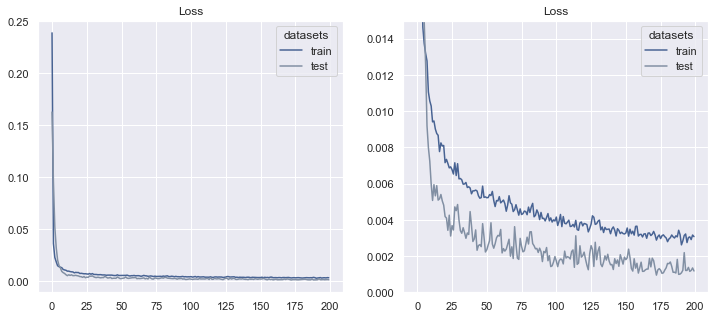

In [8]:
import seaborn as sns
sns.set(style = "darkgrid") # καθαρά αισθητικοί λόγοι

mycol = (72/255, 99/255, 147/255)
mycomplcol = (129/255, 143/255, 163/255)

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,5))
    
ax1.plot(history.history['loss'], label='train', color=mycol)
ax1.plot(history.history['val_loss'], label='test', color=mycomplcol)
ax1.legend(title = "datasets")
ax1.set_title('Loss')

ax2.plot(history.history['loss'], label='train', color=mycol)
ax2.plot(history.history['val_loss'], label='test', color=mycomplcol)
ax2.legend(title = "datasets")
ax2.set_ylim([0,0.015])
ax2.set_title('Loss')

pyplot.show()

**Ερώτηση 2**: Δοκιμάστε να τρέξετε το μοντέλο με Bottleneck: α) 50 και β) 25. Τι παρατηρείτε ως προς τα αποτελέσματα του μοντέλου;
**Ερώτηση 3**: δοκιμάστε να βάλετε τρία επίπεδα (τα δύο υφιστάμενα και ένα ακόμα με bottleneck 50). Τι διαφορές παρατηρείτε;

<font color='#486393'>Χρησιμοποιώντας τον παραπάνω κώδικα ορίζεται η συνάρτηση CustomEnc, με όρισμα το μέγεθος του Bottleneck, προκειμένου να πραγματοποιηθεί η παραπάνω διαδικασία για τις τιμές α) 50 και β) 25.</font>

In [9]:
def CustomEnc(n_bottle):

    # define encoder
    visible = Input(shape=(n_inputs,))
    e = Dense(n_inputs*2)(visible)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)
    # encoder level 2
    e = Dense(n_inputs)(e)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)
    # bottleneck
    bottleneck = Dense(n_bottle)(e) # <- Εδώ υπεισέρχεται η callable παράμετρος

    # define decoder, level 1
    d = Dense(n_inputs)(bottleneck)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)
    # decoder level 2
    d = Dense(n_inputs*2)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)
    # output layer
    output = Dense(n_inputs, activation='linear')(d)
    # define autoencoder model
    model = Model(inputs=visible, outputs=output)
    
    model.compile(optimizer='adam', loss='mse')
    
    return model

<font color='#486393'>Για την περίπτωση μεγέθους Bottleneck ίσο με 50, προκύπτουν:</font>

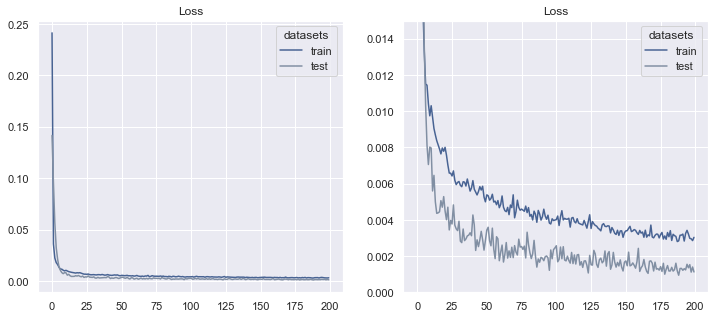

In [10]:
bot50 = CustomEnc(50)
bot50.fit(X_train, X_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,X_test))

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,5))
    
ax1.plot(bot50.history.history['loss'], label='train', color=mycol)
ax1.plot(bot50.history.history['val_loss'], label='test', color=mycomplcol)
ax1.legend(title = "datasets")
ax1.set_title('Loss')

ax2.plot(bot50.history.history['loss'], label='train', color=mycol)
ax2.plot(bot50.history.history['val_loss'], label='test', color=mycomplcol)
ax2.legend(title = "datasets")
ax2.set_ylim([0,0.015])
ax2.set_title('Loss')

pyplot.show()

<font color='#486393'>Αντίστοιχα, για Bottleneck ίσο με 25, προκύπτουν:</font>

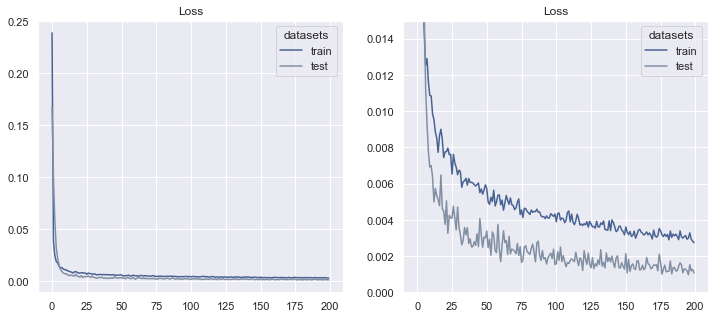

In [11]:
bot25 = CustomEnc(25)
bot25.fit(X_train, X_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,X_test))

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,5))
    
ax1.plot(bot25.history.history['loss'], label='train', color=mycol)
ax1.plot(bot25.history.history['val_loss'], label='test', color=mycomplcol)
ax1.legend(title = "datasets")
ax1.set_title('Loss')

ax2.plot(bot25.history.history['loss'], label='train', color=mycol)
ax2.plot(bot25.history.history['val_loss'], label='test', color=mycomplcol)
ax2.legend(title = "datasets")
ax2.set_ylim([0,0.015])
ax2.set_title('Loss')

pyplot.show()

<font color='#486393'>Όπως γίνεται εμφανές από τα αποτελέσματα (τα οποία επαναλήφθηκαν αρκετές φορές προκειμένου να είναι βέβαιο πως δεν είναι αποτύπωμα της εγγενούς στοχαστικότητας των μεθόδων), η επιλογή για το μέγεθος του Bottleneck δεν επηρεάζει την εκπαίδευση του Autoencoder για τις δεδομένες τιμές των παραμέτρων (όπως το πλήθος εποχών ή ο ρυθμός εκμάθησης). Η παρατήρηση αυτή ενισχύεται και από τα ακόλουθα γραφήματα, όπου οι καμπύλες σφαλμάτων για κάθε μέγεθος Bottleneck απεικονίζονται σε κοινά συστήματα αξόνων (αριστερά για train loss και δεξιά για validation loss).</font>

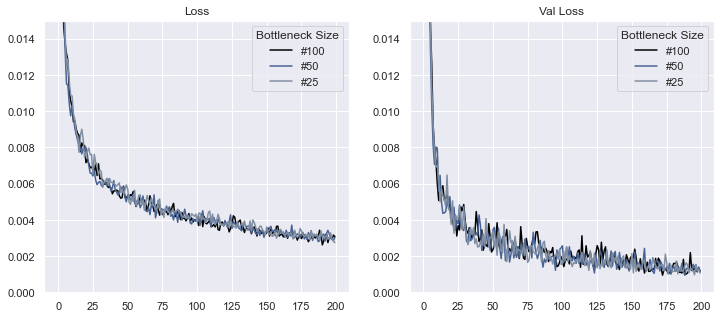

In [12]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,5))

ax1.plot(history.history['loss'], label='#100', color='black')
ax1.plot(bot50.history.history['loss'], label='#50', color=mycol)
ax1.plot(bot25.history.history['loss'], label='#25', color=mycomplcol)
ax1.legend(title = "Bottleneck Size")
ax1.set_ylim([0,0.015])
ax1.set_title('Loss')

ax2.plot(history.history['val_loss'], label='#100', color='black')
ax2.plot(bot50.history.history['val_loss'], label='#50', color=mycol)
ax2.plot(bot25.history.history['val_loss'], label='#25', color=mycomplcol)
ax2.legend(title = "Bottleneck Size")
ax2.set_ylim([0,0.015])
ax2.set_title('Val Loss')

pyplot.show()

<font color='#486393'>Η επικάλυψη που υπάρχει, ειδικά δεδομένης της κλίμακας, υποδεικνύει πως, πράγματι, το μέγεθος του Bottleneck δεν επηρεάζει την εκπαίδευση και τη γενίκευση του μοντέλου για τις επιλεγμένες τιμές των διαφόρων παραμέτρων.</font>

<font color='#486393'>Αξίζει, φυσικά, να τονιστεί πως το παραπάνω παράδειγμα δεν είναι αρκετό για την εξαγωγή γενικών συμπερασμάτων. Παρότι εδώ δεν παρατηρούνται αισθητές διαφορές ανάλογα με το bottleneck size, το γεγονός αυτό μπορεί να οφείλεται σε παραμέτρους όπως η φύση των δεδομένων εκπαίδευσης: ενδέχεται τόσο το μέγεθος 100, όσο και τα μεγέθη 50 και 25 να επαρκούν για την αποκωδικοποίηση της πληροφορίας που μεταφέρουν και το πρόβλημα να αρχίζει να εμφανίζεται για ακόμη μικρότερα μεγέθη bottleneck.</font>

<font color='#486393'>Σε ό,τι αφορά την προσθήκη ενός επιπλέον επιπέδου, το οποίο επιλέγουμε να έχει μέγεθος $n/2$ (δηλαδή 50 στην προκείμενη περίπτωση), με μέγεθος Bottleneck ίσο με 50, ο σχετικός κώδικας και τα αποτελέσματα φαίνονται ακολούθως.</font>

In [13]:
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 3
e = Dense(n_inputs/2)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
bottleneck = Dense(50)(e)

# define decoder, level 1
d = Dense(n_inputs/2)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# define level 2
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 3
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

model.compile(optimizer='adam', loss='mse')

new_history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,X_test))

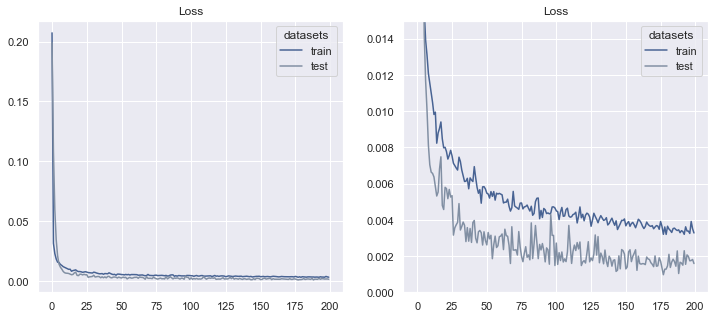

In [14]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,5))
    
ax1.plot(new_history.history['loss'], label='train', color=mycol)
ax1.plot(new_history.history['val_loss'], label='test', color=mycomplcol)
ax1.legend(title = "datasets")
ax1.set_title('Loss')

ax2.plot(new_history.history['loss'], label='train', color=mycol)
ax2.plot(new_history.history['val_loss'], label='test', color=mycomplcol)
ax2.legend(title = "datasets")
ax2.set_ylim([0,0.015])
ax2.set_title('Loss')

pyplot.show()

<font color='#486393'>Ξανά, η προσθήκη επιπλέον επιπέδων δεν οδηγεί σε αισθητές διαφορές σε ό,τι έχει σχέση με την εκπαίδευση του μοντέλου ή με το σφάλμα εκμάθησης/αξιολόγησής του. Η μόνη παρατήρηση που θα μπορούσε ενδεχομένως να γίνει, είναι πως η διασπορά στην καμπύλη που αφορά το σφάλμα αξιολόγησης είναι λίγο υψηλότερη σε σχέση με όσα είδαμε παραπάνω. Το γεγονός αυτό φαίνεται από την πιο «απότομη» ταλαντωτική συμπεριφορά που εμφανίζει η συγκεκριμένη καμπύλη, καθώς και το ελαφρώς αυξημένο πλάτος των συγκεκριμένων ταλαντώσεων - πάντα σε σχέση με την κλίμακα που απεικονίζεται στο δεύτερο γράφημα.</font>

<font color='#486393'>Όπως αναλύθηκε και παραπάνω, η παρατήρηση αυτή δεν αρκεί προκειμένου κανείς να είναι σε θέση να γενικεύσει. Όπως είναι γνωστό από την ευρύτερη περιοχή της βαθιάς μάθησης, όσο πιο πλούσια και βαθιά γίνεται η αρχιτεκτονική ενός δικτύου, τόσο περισσότερη πληροφορία μπορεί αυτό να ενσωματώσει και να αναπαραστήσει. Έτσι, θα ήταν λογικό να παρατηρείται ακόμα καλύτερη εκπαίδευση και απόδοση του autoencoder, δεδομένου ενός επιπλέον επιπέδου. Παρ' όλα αυτά, δεν είναι παράλογο το γεγονός πως κάτι τέτοιο δεν παρατηρείται, αφού η αρχική δομή του autoencoder μπορεί να είναι επαρκής για να αναπαραστήσει τα δεδομένα του συγκεκριμένου προβλήματος.</font>